# Scripts for testing the waveforms h5 files

In [1]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set plot font and size
font = {'size':14}
plt.rc('font', **font)

# Uncomment next two lines if romSpline is not in your PYTHONPATH
#import sys
#sys.path.append('/localdata/bkhamesra3/research_localdata/UsefulScripts/LIGO/LIGO_Scripts/LIGO_Waveforms_Scripts/')

import romspline, os, glob, h5py
import shutil as sh

import sys, random
sys.stdout.flush()

/localdata/bkhamesra3/softwares/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.chdir('/numrel/NumRel/bkhamesra3/Finalized_Waveforms/')

In [34]:
# Function Definitions:

def write_data(data, filename, filepath, hdr=""):
    strfile = open(os.path.join(filepath, filename), 'w')
    np.savetxt(strfile, data, delimiter='\n', header=hdr)
    strfile.close()
    
def filesearch(wfdir, l, m):
                   
    for f in sorted(glob.glob(wfdir+'/data/Strain/Strain_TimeShifted/*.asc')):
       
        filename = os.path.basename(f)
        ll = int(filename.split('_')[1][0])
        mm = int(filename.split('_')[1][1:])
        if l == ll and m == mm:
            strorig_file = f
            return strorig_file
        

In [31]:
#Specify the waveform name here which you wish to test

waveform = 'GT0370'
verbose = False

if not glob.glob('H5Files/*/%s.h5'%waveform):
    raise RuntimeError("File not found")


h5path = glob.glob('H5Files/NonSpinning/%s.h5'%waveform)[0]
h5file = h5py.File(h5path)

## Checking errors from spline interpolation

* Read data (metadata, amplitude and phase) from  h5 file
* Write into text files and Create spline interpolant 
* Extract amplitude and phase using this interpolant
* Read the original data
* Compare the spline interpolant of amplitude and phase at random time points from original data
* Compute the errors
* Compute the frequencies



In [32]:

#Extract the metadata from h5
metadata = {}

for item in h5file.attrs.keys():
    metadata[item] = h5file.attrs[item]


#Extract the amplitude and phase from h5. If a field is missing, send it to failed directory
wfdir = 'Waveform_files/Completed/*/%s'%metadata['alternative-names']
failed_h5path = 'trash/Failed/H5Files/'
failed_wfpath = 'trash/Failed/Waveforms/'
amp, phase = {}, {}

for key in h5file.keys():
    if key[:3] =="amp":
        amp_lm =  h5file[key]
        ampkey = amp_lm.keys()
        
        if len(ampkey)==0:
            sh.move(h5path, failed_h5path)
            sh.move(wfdir, failed_wfpath)
            
        t_val   =  amp_lm[ampkey[0]][:]
        amp_val = amp_lm[ampkey[1]][:]
        deg_val = amp_lm[ampkey[2]].value
        err_val = amp_lm[ampkey[3]][:]
        tol_val = amp_lm[ampkey[4]].value
      
        amp[key] = {"X":t_val, "Y":amp_val, "deg":deg_val, "tol":tol_val, "errors":err_val}
        
    elif key[:3] =="pha":
        ph_lm =  h5file[key]
        phkey = ph_lm.keys()
        
        if len(phkey)==0:
            sh.move(h5path, failed_h5path)
            sh.move(wfdir, failed_wfpath)
            
        t_val   =  ph_lm[phkey[0]][:]
        ph_val  = ph_lm[phkey[1]][:]
        deg_val = ph_lm[phkey[2]].value
        err_val = ph_lm[phkey[3]][:]
        tol_val = ph_lm[phkey[4]].value
        
        phase[key] = {"X":t_val, "Y":ph_val, "deg":deg_val, "tol":tol_val, "errors":err_val}
        
    
    


IOError: [Errno 2] No such file or directory: 'Waveform_files/Completed/*/D10_a0.0_q1.15_m103_Qs/figures/Strain/Amp_22_InterpolationCheck.png'

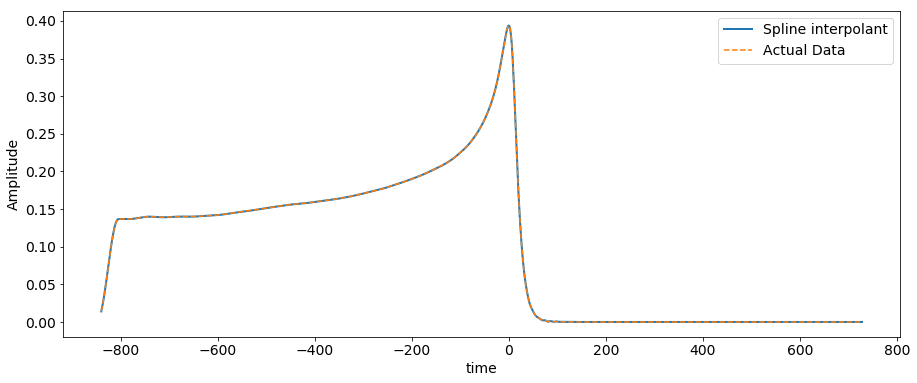

In [37]:
#Create text file directories to create spline object:

if not os.path.exists('./.testdir/amp_lm.txt/'):
    os.makedirs('./.testdir/amp_lm.txt/')
    
ll_desired = 2
mm_desired = 2

if verbose:
    print("Errors in Amplitude for all the modes")
    print("#l \t m \t Abs Error \t Amp")


for key in sorted(amp.keys()):
    
    l = int(key.split('l')[1][0])
    m = int(key.split('m')[2])

    if m==0: continue
    
    pathfile = './.testdir/amp_lm.txt'
   
    #Write the data from dictionaries into text files - conversion of h5 into txt file 
    for k in amp[key].keys():
        
        if isinstance(amp[key][k], (list, tuple, np.ndarray)):
            data = np.column_stack(amp[key][k])
            write_data(data, k+'.txt', pathfile, hdr="")

        else:
            data = amp[key][k]
            strfile = open(os.path.join(pathfile, ( k + '.txt')),'w')
            strfile.write(str(data))
            strfile.close()
            
   
    #Create the spline object using data from txt files
    #Comment: There should be easier way to read the spline data from h5 directly but need to figure it out
    
    s1 = romspline.readSpline('./.testdir/amp_lm.txt')
    
    
    # Locate the file with original data  
    strorig_file = filesearch(wfdir, l, m)
    
    if not os.path.exists(strorig_file): raise IOError("%s file not found"%os.path.basename(strorig_file))
        
        
    #Read the original time, amplitude and phase data 
    t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
    
    #Select time values from original time array - useful to compare the errors later
    #time =  np.sort([random.uniform(t_orig.min(), t_orig.max()) for ii in range(len(t_orig/100))])
    time =  np.copy(t_orig[::10])

    
    #Compute the errors from spline interpolation - Here we look at absolute errors since amplitude is quite small at
    #at later times which results in inf/nan values
    error_amp = []
    amp_values = []
    
    for tvar in time[0:]:
        
        idx = np.asscalar(np.argwhere(tvar==t_orig))
        err_amp = (amp_orig[idx] - s1(tvar))
        
        amp_values.append(amp_orig[idx])
        error_amp.append(err_amp)
        
    error_amp = np.asarray(error_amp)
    error_amp = error_amp[~np.isnan(error_amp)]
    
    #Compute the maximum error for each mode. 
    if len(error_amp)>0:
        max_error = np.amax(error_amp)
        amp_maxerr = np.asarray(amp_values)[error_amp==max_error]
        if verbose:
            print("%d \t %d \t %g \t %g"%(l, m, max_error, amp_maxerr))

    #Plot the phase for desired phase mode
    if (l==ll_desired and m==mm_desired):
        #Read the original phase and amplitude data 
        t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
    
        plt.figure(figsize=(15,6))

        plt.plot(time, s1(time),lw=2, label='Spline interpolant')
        plt.plot(t_orig, amp_orig,lw=1.5,  label='Actual Data', ls='--')
        plt.xlabel('time', fontsize=14)
        plt.ylabel('Amplitude', fontsize=14)
        plt.tick_params(labelsize=14)
        plt.legend( fontsize=14)
        plt.savefig(os.path.join(wfdir, 'figures/Strain/')+'Amp_22_InterpolationCheck.png', dpi=500)
        plt.show()
        plt.close()

   

sh.rmtree('./.testdir/amp_lm.txt')
    
    
     
    



In [ ]:
#Create text file directories to create spline object:

if not os.path.exists('./.testdir/phase_lm.txt/'):
    os.makedirs('./.testdir/phase_lm.txt/')
    

if verbose:
    print("Errors in Phase for all the modes")
    print("#l \t m \t Abs Error from Spline Interpolation \t Phase @ error value")

    
for key in phase.keys():
    
    
    #Extract l,m mode from key
    l = int(key.split('l')[1][0])
    m = int(key.split('m')[1])
   
    if m==0:continue
    
    pathfile = './.testdir/phase_lm.txt'
   
    #Write the data from dictionaries into text files
    for k in phase[key].keys():
       
        if isinstance(phase[key][k], (list, tuple, np.ndarray)):
            data = np.column_stack(phase[key][k])
            
            strfile = os.path.join(pathfile, ( k + '.txt'))
            np.savetxt(strfile, data, delimiter='\n')
        else:
            data = phase[key][k]
            strfile = open(os.path.join(pathfile, ( k + '.txt')),'w')
            strfile.write(str(data))
            strfile.close()
            
   
    #Read the data using romspline to create spline object
    s2 = romspline.readSpline('./.testdir/phase_lm.txt')
    
    
    #Find the original data file and read the time, amplitude and phase data
    strorig_file = filesearch(wfdir, l, m)

    if not os.path.exists(strorig_file): raise IOError("%s file not found"%os.path.basename(strorig_file))
   
    t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
    
    
    #Create a time array - Here I select the time values from the original data which can be used to compute 
    #the errors of interpolation
    
    time =  np.copy(t_orig[::10])
    #time =  np.sort([random.uniform(t_orig.min(), t_orig.max()) for ii in range(len(t_orig))])

    
    #Compute the errors 
    error_phase = []
    phase_values = []
    
    for tvar in time[0:]:
        
        idx = np.asscalar(np.argwhere(tvar==t_orig))
        err_phase = (phase_orig[idx] - s2(tvar))/phase_orig[idx]
    
        phase_values.append(phase_orig[idx])
        error_phase.append(err_phase)
        
    error_phase = np.asarray(error_phase)
    error_phase = error_phase[~np.isnan(error_phase)]    #Remove nan values - can occur if denominator is extremely small
    
    
    #Compute the max error for each mode
    if len(error_phase)>0:
        max_error = np.amax(error_phase)
        phase_maxerr = np.asarray(phase_values)[error_phase==max_error]
        print("%d \t %d \t %g \t %g"%(l, m, max_error, phase_maxerr))
     
    
    #Compute the frequency
    if l ==2 and m==2:
        freq_real = (np.gradient(phase_orig)/np.gradient(t_orig))[0]
        freq_h5 = (np.gradient(s2(time))/np.gradient(time))[0]
    
    
    #Plot the phase for desired phase mode
    if l==ll_desired and m==mm_desired:
        plt.figure(figsize=(15,8))
        
        plt.subplot(211)
        plt.plot(time, s2(time), lw=2, label='Spline interpolant')
        plt.plot(t_orig, phase_orig, lw=1.5,  label='Actual Data', ls='--')
        plt.xlabel('time', fontsize=14)
        plt.ylabel('Phase (2,2)', fontsize=14)
        plt.tick_params(labelsize=14)
        plt.legend( fontsize=14)
        
        plt.subplot(212)
        plt.plot(time, error_phase*100, label="Percent Error")
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('% Error', fontsize=14)
        plt.tick_params(labelsize=14)
        plt.show()
        plt.savefig(os.path.join(wfdir, 'figures/Strain/')+'Phase_22_InterpolationCheck.png', dpi=500)
        plt.close()
    
    
    
sh.rmtree('./.testdir/phase_lm.txt')


    
    



Plot the test data to see how it looks.

In [38]:
G = 6.67428e-11 # m^3/(kg s^2)
mass_sun = 1.98892e30 # kg
c = 2.99792458e8 # m/s
mass_sec = G * mass_sun / ( c*c*c )
simulation_mass_sec = ( 1.0 ) * mass_sec # NOTE that the 1.0 here is for 1solar mass



freq_metadata = metadata['f_lower_at_1MSUN']
freq_h5_Hz    = freq_h5/(2.*np.pi)/simulation_mass_sec
freq_real_Hz  = freq_real/(2.*np.pi)/simulation_mass_sec

print('Frequency from metadata      = %g Hz'%freq_metadata)
print('Frequency from original data = %g Hz'%freq_real_Hz)
print('Frequency from h5            = %g Hz'%freq_h5_Hz)


Frequency from metadata      = 1933.07 Hz
Frequency from original data = -1933.07 Hz
Frequency from h5            = -1927.5 Hz


## Building a reduced-order spline

Create a reduced-order spline by making an instance of the `ReducedOrderSpline` class.

In [ ]:
spline = romspline.ReducedOrderSpline(t, phase, verbose=True)

# Additional options include:
#     deg -- degree of interpolating spline polynomials (default is 5)
#     tol -- tolerance of greedy algorithm (default is 1e-6)
#     rel -- use relative errors if True (default is False)

Because data, namely, $x$ and $f(x)$, are given then the class goes ahead and builds the
reduced-order spline via a greedy algorithm. The number of optimal points and the 
resulting compression factor are:

In [ ]:
print "Number of optimal points:", spline.size
print "Compression factor:", spline.compression

Plot the max L-infinity errors that were found in building the "optimal" spline.
These errors are sometimes called "greedy errors" since they are computed
in a greedy algorithm. Notice that the decay is polynomial (power is deg+1) 
and not exponential. This is because the spline is only smooth to the degree of 
the polynomial used. For this reason, it's good not to set the tolerance too high 
(e.g., numerical round-off) as the time to generate spline might be impractically 
long.

In [ ]:

plt.figure(figsize=(15,6))
plt.loglog(spline.errors, 'k-');
plt.ylabel('Max absolute spline errors', fontsize=14);
plt.xlabel('Size of reduced data', fontsize=14);
plt.tick_params(labelsize=14)

The distribution of the "optimal" points (called $X$ in the code) 
is not uniform. Generally speaking, the density of the points is 
highest around the data that exhibits more variations.

In [ ]:
plt.figure(figsize=(15,6))
plt.hist(spline.X, 20, color='k', alpha=0.33)
plt.plot(t, phase, 'k-')
plt.xlabel('$x$', fontsize=14);
plt.ylabel('phase', fontsize=14);
plt.tick_params(labelsize=14)

## Evaluating a reduced-order spline

To evaluate the reduced-order spline let's first create an array of new randomly selected samples from the same interval as the `x` array:

In [ ]:
import random
tt = np.sort([random.uniform(t.min(), t.max()) for ii in range(10000)])

Then use the `eval` method to evaluate the spline.

In [ ]:
phi_spline = spline.eval(tt)

You could also just call `spline` directly as follows:

In [ ]:
y2 = spline(tt)

Both ways of evaluating the spline are equivalent, namely, their difference is an array of zeros

In [ ]:
np.all(np.abs(phi_spline-y2) == 0.)

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(tt, phi_spline, label='Spline Interpolation')
plt.plot(t, phase,ls = '--', label='Original Data')
plt.xlabel('t', fontsize=14)
plt.ylabel('Phase', fontsize=14)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.show()

## Exporting/importing reduced-order spline data to/from file

`romSpline` provides functions to write the relevant spline interapolant data to HDF5 and text formats by calling the `write method`. The `write` method is fairly flexible as you can enter a filename, an HDF5 file descriptor, or an HDF5 group descriptor (if you have multiple reduced-order spline interpolants to export). 

In [ ]:
# Write data to HDF5 file given a filename
spline.write("test1.h5")

# Write data to HDF5 file by passing a file descriptor
import h5py
with h5py.File('test1a.h5', 'w') as fd:
    spline.write(fd)

# Write data to HDF5 file by passing a group descriptor
with h5py.File('test1b.h5', 'w') as fd:
    group = fd.create_group('this_is_a_group')  # This is a group descriptor called "group"
    spline.write(group)

The interpolant data can also be written in a text format by simply passing a filename with ".txt" extension. The `write` method creates a directory with the given filename and creates a separate text file for each piece of interpolant data.

In [ ]:
spline.write('test1.txt')

The `write` method has a keyword option called "slim" (default is False) that writes only the reduced data as well as the polynomial degree (`deg`) and greedy tolerance (`tol`). This is the minimum data needed to reconstruct the reduced-order spline interpolant. In particular, the array of greedy errors is not written to file when `slim` is True.

Next, let's pretend you've already saved the reduced-order spline data to file and want to reconstruct and evalute the interpolant. Fortunately, one doesn't need to rerun the greedy algorithm. Instead, use the `read` method of the `ReducedorderSpline` class.

In [ ]:
s = romspline.ReducedOrderSpline()  # Don't initialize with anything
print "Is spline made/available?", s._made  # Reduced-order spline is not made/available

s.read('test1.h5')  # Load interpolant data
print "Is spline made/available?", s._made  # Reduced-order spline is made/available

You can check that data was actually loaded by simply evaluating the spline at the samples `xx`.

In [ ]:
s(xx)

One doesn't need to create a ReducedOrderSpline object to import the data of a previously generated reduced-order spline if one uses the `readSpline` function. This function can read both HDF5 and text file formats provided that the files were created with romSpline's `write` function discussed above. Recall that the `write` function creates a directory of text files when requesting text format.

In [ ]:
# Read from HDF5 file
s_h5 = romspline.readSpline('test1.h5')
print s_h5(xx)

# Read from text file(s)
s_txt = romspline.readSpline('test1.txt')
print s_txt(xx)

## Some other basic features and functions

The `ReducedOrderSpline` class comes with a function called `test` that simply compares the interpolated values of the reduced-order spline to some set of "truth" data, which in this example are the function values themselves. Below is shown the absolute difference between these two sets of values. Also plotted in blue is the tolerance of the greedy algorithm ($10^{-6}$ here).

In [ ]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-');
plt.semilogy(xx, spline.tol*np.ones_like(xx), 'b-');
plt.ylim(1e-11, 1e-5);
plt.xlabel('$x$');
plt.ylabel('Errors');

We can rerun the greedy algorithm to make a reduced-order spline with a different tolerance, for example. Using the same object `spline` (or you can create a new one), we run the greedy method:

In [ ]:
spline.greedy(x, f(x), tol=1e-3)

When we made our first reduced-order spline above, we were actually calling the `greedy` method. When the `ReducedOrderSpline` class is initialized with data (i.e., samples and values) then the `greedy` method is executed on that data. If only values are given (i.e., no samples, like $x$) then the `greedy` method is executed but the samples are assumed to be integers from zero to the number of values less one.

And let's plot the interpolation errors at the samples `xx` like we did earlier.

In [ ]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-');
plt.semilogy(xx, spline.tol*np.ones_like(xx), 'b-');
plt.ylim(1e-8, 1e-2);
plt.xlabel('$x$');
plt.ylabel('Errors');

You can write this spline data to file, just as before.

In [ ]:
spline.write('test2.h5')   # In HDF5 format
spline.write('test2.txt')  # In text format

A reduced-order spline can also be built where the tolerance is defined relative to the maximum of the abolute value of the data. This can be done using the `rel` option. The tolerance that is being input is the desired relative tolerance (i.e., $10^{-3}$ relative to the largest absolute data value).

In [ ]:
spline.greedy(x, f(x), tol=1e-3, rel=True)

print "The compression factor is:", spline.compression
print "The (relative) tolerance requested is", spline._tol
print "The (absolute) tolerance used is:", spline.tol, spline._tol * np.max(np.abs(f(x)))

Let's plot the interpolation error on the random samples `xx` to see how they compare to the relative tolerance, which the code translates into an absolute tolerance that depends on the largest absolute data value in the array.

In [ ]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-', 
            xx, spline._tol*np.ones(xx.size), 'b--',  # Requested relative tolerance (_tol)
            xx, spline.tol*np.ones(xx.size), 'b-'     # Actual absolute tolerance used (tol)
);
plt.xlabel('$x$');
plt.ylabel('Errors');

## Reduced-order splines and derivatives

The spline interpolation functionality is achieved using `scipy.interpolate`'s class called  `UnivariateSpline`. As a result, we have direct access to derivatives of the spline. The number of derivatives available to us equals to the polynomial degree used to build the spline. Otherwise, `UnivariateSpline` throws an error.

Let's build a spline with absolute tolerance of $10^{-3}$ and using fifth degree polynomials.

In [ ]:
spline = romspline.ReducedOrderSpline(x, f(x), tol=1e-3)
print "Size of spline =", spline.size
print "Compression factor =", spline.compression

The first derivative of the spline on the random samples `xx` is found by evaluating the spline as described (recall, there are two ways to do this) above but entering an integer (for the number of derivatives we want) for the `dx` option:

In [ ]:
spline(x, dx=1)

However, we will incur some additional errors because the interpolation approximation is being differentiated, not the function data. To see this more clearly, we can build a reduced-order spline for the first derivative of the function values, which can be calculated analytically:

In [ ]:
def dfdx(x):
    """Analytic derivative of f(x) test data"""
    a = 10.*(-0.2+x)*(1.+x)*np.cos(5.*(-0.2 + x)**2)
    b = 100.*np.exp(-50.*(-0.5+x)**2)*np.cos(100.*x)
    c = np.sin(5.*(-0.2+x)**2)
    d = -100.*np.exp(-50.*(-0.5+x)**2)*(-0.5+x)*np.sin(100.*x)
    return 100.*(a+b+c+d)

Now, generate the reduced-order spline for the `dfdx` data and plot the derivative of the spline together with the spline of the derivative.

In [ ]:
# Reduced-order spline of the analytic derivative:
dspline = romspline.ReducedOrderSpline(x, dfdx(x), tol=1e-3)

plt.plot(xx, spline(xx, dx=1), 'b-');  # Derivative of spline built for f(x)
plt.plot(xx, dspline(xx), 'r--');      # Spline built for derivative of f(x)
plt.xlabel('$x$');
plt.ylabel('$df/dx$');

By the eyeball norm the two interpolation predictions seem to agree but there actually is a difference in this case. The spline computed for the derivative of the data tends to be more accurate than computing the derivative of the spline built for the $f(x)$ data.

In [ ]:
y = f(x)      # Store function values
y1 = dfdx(x)  # Store analytically calculated derivative

# This tests the first derivative of the spline prediction and compares to y1
plt.semilogy(x, spline.test(x, y1, dx=1), 'b-', alpha=0.5);  

# This tests the spline prediction of the first derivative of the data 
# and compares to y1
plt.semilogy(x, dspline.test(x, y1), 'r-', alpha=0.5);

plt.semilogy(x, dspline.tol*np.ones(x.size), 'k--');
plt.ylabel('Errors');
plt.xlabel('$x$');

As you can see above, the red curve is below the tolerance used in the greedy algorithm (i.e., $10^{-3}$). Note that the plot is generated at the samples $x$ used to train the greedy algorithm for building both splines. However, only the spline built from the derivatives of the data are actually guaranteed to have errors below the tolerance.

To summarize, you can compute derivatives with a reduced-order spline (or, any other spline, in fact) but additional errors will be accrued in the process. So, please have this in mind if your application involves derivatives. You can retain accuracy by instead building a reduced-order spline specifically for the derivatives.

If we didn't have access to the analytical derivative of the data then we can use finite-difference differentiation to numerically compute the derivative and build a spline for that data. This is achieved using the `D` function in `romSpline`.

In [ ]:
# Compute numerical derivative of data
Df = romspline.D(f(x), x)  # Default options: dx=1, order=4

# Build a reduced-order spline for the numerical derivative
Dspline = romspline.ReducedOrderSpline(x, Df, tol=1e-3)
print "Size of spline =", Dspline.size
print "Compression factor =", Dspline.compression

# Notice that more points are needed for the derivative. This happens
# because we are imposing a tol on the *absolute* error of 1e-3 here
# and the derivative is large for some values of x.

Notice that the reduced data size is larger for building a reduced-order spline for the derivative of the data. This happens, in part, because we are imposing an absolute tolerance of $10^{-3}$ here and the derivative can be large at some samples.

As in the case with the analytical derivatives studied above, the spline built from the numerical derivative (`Dspline`) is more accurate than evaluating the derivative of the spline built from the original data (`spline`).

In [ ]:
plt.semilogy(x, spline.test(x, y1, dx=1), 'b-', alpha=0.5);
plt.semilogy(x, Dspline.test(x, Df), 'r-', alpha=0.5);
plt.semilogy(x, Dspline.tol*np.ones(x.size), 'k--');
plt.xlabel('$x$');
plt.ylabel('Errors');

In [ ]:
from IPython.display import Image
Image("/numrel/NumRel/bkhamesra3/Finalized_Waveforms/Waveform_files/Completed/NonSpinning/D11_q2.00_a0.0_m200/figures/AmpPhase_22_Comparison.png")


In [15]:
alpha = np.arange(0,100,1)

idx = np.asscalar(np.argwhere(alpha==20))
print idx

20
